#FINAL EXPORT (BEST MODEL)

In [2]:
from pathlib import Path
import subprocess

ROOT = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())


In [3]:

# # FINAL EXPORT (BEST MODEL) — NN baseline without rolling7 (Kaggle ~0.19488)

# %%
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from tensorflow import keras

# 1) Load data


train_path = ROOT / "data" / "processed" / "df_train_data_cleaned.csv"
val_path   = ROOT / "data" / "processed" / "df_validation_data_cleaned.csv"
test_path  = ROOT / "data" / "processed" / "df_test_data_cleaned.csv"



df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

#add month to all datasets
df_train['month'] = pd.to_datetime(df_train['Datum']).dt.month
df_val['month'] = pd.to_datetime(df_val['Datum']).dt.month
df_test['month'] = pd.to_datetime(df_test['Datum']).dt.month

#is_last_day_of_year
df_train['is_last_day_of_year'] = pd.to_datetime(df_train['Datum']).dt.is_year_end.astype(int)
df_val['is_last_day_of_year'] = pd.to_datetime(df_val['Datum']).dt.is_year_end.astype(int)
df_test['is_last_day_of_year'] = pd.to_datetime(df_test['Datum']).dt.is_year_end.astype(int)

for df in (df_train, df_val, df_test):
    df["Datum"] = pd.to_datetime(df["Datum"], errors="coerce")

target = "Umsatz_umsatz"

# 2) Split X/y
X_train = df_train.drop(columns=[target, "Datum"])
y_train = df_train[target].astype(float)

X_val = df_val.drop(columns=[target, "Datum"])
y_val = df_val[target].astype(float)

# test has no target
X_test = df_test.drop(columns=["Datum"])

# 3) Drop rolling7 (best model)
drop_cols = ["umsatz_rolling7","temperature_2m_mean","sunshine_duration","is_saturday","is_sunday","next_day_holiday"]
X_train = X_train.drop(columns=drop_cols, errors="ignore")
X_val   = X_val.drop(columns=drop_cols, errors="ignore")
X_test  = X_test.drop(columns=drop_cols, errors="ignore")

# 4) Ensure categorical as string
cat_cols = ["Warengruppe_umsatz", "day_of_week", "KielerWoche_kiwo", "month","is_last_day_of_year"]
for df in (X_train, X_val, X_test):
    df["Warengruppe_umsatz"] = df["Warengruppe_umsatz"].astype(int).astype(str)

# 5) Align columns (very important)
# make sure val/test have exactly same feature columns as train
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 6) Preprocess (scaling + one-hot)
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

# display x_train before training
display(X_train.head())

2026-02-16 22:09:40.207238: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-16 22:09:40.517754: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-16 22:09:56.905855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-16 22:10:08.370024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Warengruppe_umsatz,day_of_week,sunshine_hours,public_holiday,school_holiday,month,is_last_day_of_year
0,0.0,6.0,17.8375,15.0,1,0,8.618242,0.0,1.0,7,0
1,0.0,6.0,17.8375,15.0,2,0,8.618242,0.0,1.0,7,0
2,0.0,6.0,17.8375,15.0,3,0,8.618242,0.0,1.0,7,0
3,0.0,6.0,17.8375,15.0,4,0,8.618242,0.0,1.0,7,0
4,0.0,6.0,17.8375,15.0,5,0,8.618242,0.0,1.0,7,0


In [4]:
X_train_p = preprocess.fit_transform(X_train)
# display column name from X_train_p
print("Preprocessed feature names:")
num_features = preprocess.named_transformers_["num"].get_feature_names_out(num_cols)
print(num_features)
print("categorical features:")
cat_features = preprocess.named_transformers_["cat"].get_feature_names_out(cat_cols)
print(cat_features)


X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)
print("Shapes:", X_train_p.shape, X_val_p.shape, X_test_p.shape)

Preprocessed feature names:
['Bewoelkung_weather' 'Temperatur_weather' 'Windgeschwindigkeit_weather'
 'sunshine_hours' 'public_holiday' 'school_holiday']
categorical features:
['Warengruppe_umsatz_1' 'Warengruppe_umsatz_2' 'Warengruppe_umsatz_3'
 'Warengruppe_umsatz_4' 'Warengruppe_umsatz_5' 'Warengruppe_umsatz_6'
 'day_of_week_0' 'day_of_week_1' 'day_of_week_2' 'day_of_week_3'
 'day_of_week_4' 'day_of_week_5' 'day_of_week_6' 'KielerWoche_kiwo_0.0'
 'KielerWoche_kiwo_1.0' 'month_1' 'month_2' 'month_3' 'month_4' 'month_5'
 'month_6' 'month_7' 'month_8' 'month_9' 'month_10' 'month_11' 'month_12'
 'is_last_day_of_year_0' 'is_last_day_of_year_1']
Shapes: (7487, 35) (1841, 35) (1830, 35)


### Training

In [5]:



# 7) Build + train NN (same architecture)
tf.random.set_seed(42)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_p.shape[1],)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="mape",                 # to match Kaggle metric
    metrics=["mae"]
)

early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early],
    verbose=1
)

# quick sanity check on val (MAPE)
pred_val = model.predict(X_val_p).ravel()
pred_val = np.clip(pred_val, 0, None)
val_mape = mean_absolute_percentage_error(y_val, pred_val) * 100
print(f"Validation MAPE %: {val_mape:.2f}")

# 8) Predict test + create submission
pred_test = model.predict(X_test_p).ravel()
pred_test = np.clip(pred_test, 0, None)

submission = df_test[["id"]].copy()
submission["umsatz"] = pred_test

out_path   = ROOT / "data" / "processed" / "submission_nn_best.csv"
submission.to_csv(out_path, index=False)

print("Saved:", out_path)
print("rows:", len(submission))
print("pred mean/min/max:",
      float(submission["umsatz"].mean()),
      float(submission["umsatz"].min()),
      float(submission["umsatz"].max()))
print(submission.head())


Epoch 1/200


2026-02-16 22:10:10.898622: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 85.3362 - mae: 189.6405 - val_loss: 53.0595 - val_mae: 129.6694
Epoch 2/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 47.1766 - mae: 122.6625 - val_loss: 41.1797 - val_mae: 100.0366
Epoch 3/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 41.7445 - mae: 107.6007 - val_loss: 36.7719 - val_mae: 88.0793
Epoch 4/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.2363 - mae: 94.1006 - val_loss: 31.7673 - val_mae: 73.8271
Epoch 5/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 31.7957 - mae: 77.2399 - val_loss: 26.4032 - val_mae: 57.5548
Epoch 6/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.9962 - mae: 61.9846 - val_loss: 24.2883 - val_mae: 49.8144
Epoch 7/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24.7875 - mae: 54.8372 - val_loss: 23.6088 - val_mae: 47.4689
Epoch 8/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.8587 - mae: 51.8752 - val_loss: 23.1396 - val_mae: 45.8644
Epoch 9/200
234/234 ━━━

In [6]:
print("y_train min/max:", y_train.min(), y_train.max())
print("pred_val min/max:", pred_val.min(), pred_val.max())

y_train min/max: 12.9373828412174 1879.46183076734
pred_val min/max: 23.631891 689.2276


In [7]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# predictions already computed: pred_val
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
r2   = r2_score(y_val, pred_val)
mae  = mean_absolute_error(y_val, pred_val)

print(f"Validation MAPE %: {val_mape:.2f}")
print(f"Validation RMSE : {rmse:.2f}")
print(f"Validation R2   : {r2:.4f}")
print(f"Validation MAE  : {mae:.2f}")

Validation MAPE %: 17.71
Validation RMSE : 49.92
Validation R2   : 0.8527
Validation MAE  : 30.86


#Plot 1: Loss curves (Train vs Val)

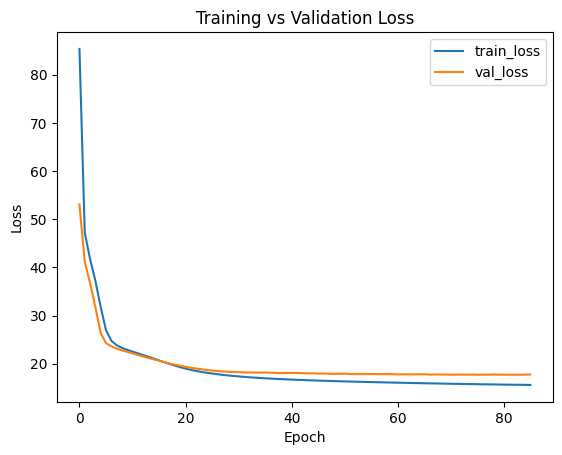

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


#Plot 2: Actual vs Pred (Validation)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


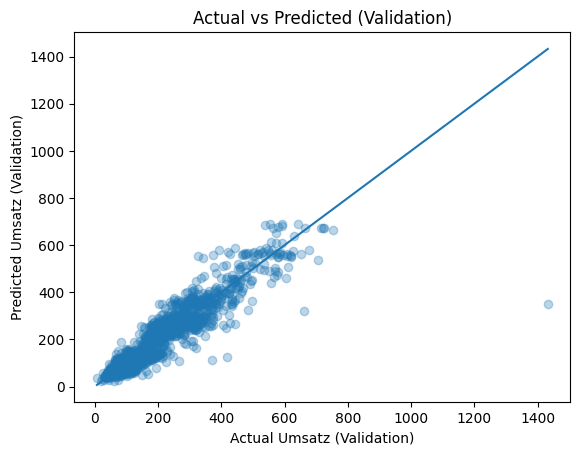

In [9]:
import numpy as np
import matplotlib.pyplot as plt

pred_val = model.predict(X_val_p).ravel()
pred_val = np.clip(pred_val, 0, None)

plt.figure()
plt.scatter(y_val, pred_val, alpha=0.3)
plt.xlabel("Actual Umsatz (Validation)")
plt.ylabel("Predicted Umsatz (Validation)")
plt.title("Actual vs Predicted (Validation)")

mn = min(y_val.min(), pred_val.min())
mx = max(y_val.max(), pred_val.max())
plt.plot([mn, mx], [mn, mx])
plt.show()


#MAPE Overall + each Product Group (Warengruppe)

In [10]:
import pandas as pd
import numpy as np

# Predictions on validation
pred_val = model.predict(X_val_p).ravel()
pred_val = np.clip(pred_val, 0, None)

# overall MAPE
overall_mape = np.mean(np.abs((y_val.values - pred_val) / y_val.values)) * 100
print(f"Overall Validation MAPE: {overall_mape:.2f}%")

# per-group MAPE
val_results = df_val[["Warengruppe_umsatz"]].copy()
val_results["y_true"] = y_val.values
val_results["y_pred"] = pred_val

mape_by_group = (
    val_results
    .groupby("Warengruppe_umsatz")
    .apply(lambda g: np.mean(np.abs((g["y_true"] - g["y_pred"]) / g["y_true"])) * 100)
    .reset_index(name="MAPE_%")
    .sort_values("MAPE_%", ascending=False)
)

display(mape_by_group)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Overall Validation MAPE: 17.71%


/tmp/ipykernel_39109/3864057258.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.mean(np.abs((g["y_true"] - g["y_pred"]) / g["y_true"])) * 100)


,Warengruppe_umsatz,MAPE_%
5,6.0,36.958046
3,4.0,21.970738
0,1.0,18.782311
2,3.0,17.235173
4,5.0,14.012975
1,2.0,13.550882


#Worst Fail & Best Improvement:

In [11]:
import numpy as np

val_results = df_val[["Datum","Warengruppe_umsatz"]].copy()
val_results["y_true"] = y_val.values
val_results["y_pred"] = np.clip(model.predict(X_val_p).ravel(), 0, None)

# APE  
val_results["APE_%"] = np.abs((val_results["y_true"] - val_results["y_pred"]) / val_results["y_true"]) * 100

# Worst Fail
worst = val_results.sort_values("APE_%", ascending=False).head(10)
print("Worst Fail examples:")
display(worst)

# Baseline : mean per product group (on train)
group_mean_train = df_train.groupby("Warengruppe_umsatz")["Umsatz_umsatz"].mean()

val_results["baseline_pred"] = val_results["Warengruppe_umsatz"].map(group_mean_train)
val_results["baseline_APE_%"] = np.abs((val_results["y_true"] - val_results["baseline_pred"]) / val_results["y_true"]) * 100

# Best improvement = baseline_APE - model_APE
val_results["improvement_%"] = val_results["baseline_APE_%"] - val_results["APE_%"]
best_improve = val_results.sort_values("improvement_%", ascending=False).head(10)

print("Best Improvement examples:")
display(best_improve)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Worst Fail examples:


,Datum,Warengruppe_umsatz,y_true,y_pred,APE_%
529,2017-11-14,6.0,7.051201,37.359978,429.838501
768,2017-12-23,3.0,83.567655,187.346268,124.185144
799,2017-12-31,4.0,44.175829,96.710274,118.921241
1499,2018-05-24,4.0,27.433726,56.941277,107.559399
1293,2018-04-11,3.0,68.024510,139.744919,105.433187
392,2017-10-18,3.0,74.710788,149.353653,99.909086
1373,2018-04-27,1.0,64.073617,113.340050,76.890357
1484,2018-05-20,4.0,65.418787,115.555786,76.640062
147,2017-08-30,3.0,146.947497,258.011841,75.580970
800,2017-12-31,5.0,1432.422347,351.627686,75.452234


Best Improvement examples:


,Datum,Warengruppe_umsatz,y_true,y_pred,APE_%,baseline_pred,baseline_APE_%,improvement_%
529,2017-11-14,6.0,7.051201,37.359978,429.838501,66.899353,848.765364,418.926863
583,2017-11-23,6.0,19.282251,24.806120,28.647426,66.899353,246.947832,218.300407
875,2018-01-16,3.0,56.309310,78.899071,40.117275,164.134578,191.487460,151.370185
1249,2018-04-02,1.0,43.200365,56.222126,30.142711,121.378311,180.965939,150.823228
1141,2018-03-11,1.0,44.514173,57.939468,30.159596,121.378311,172.673401,142.513805
456,2017-11-01,6.0,23.868179,33.938755,42.192474,66.899353,180.286785,138.094310
708,2017-12-13,3.0,54.560606,89.304260,63.679012,164.134578,200.829832,137.150819
1125,2018-03-07,3.0,58.989914,83.258980,41.141044,164.134578,178.241767,137.100723
477,2017-11-05,6.0,28.382096,27.027544,4.772557,66.899353,135.709701,130.937145
711,2017-12-14,3.0,63.026665,84.699455,34.386699,164.134578,160.420850,126.034151
